<a href="https://colab.research.google.com/github/gaikwad411/Leaflet/blob/master/VNIT_Mini_Proj_v2_MT24AAI195.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mini Project: Toxic Text Content classification - Colab code used for model training
### Name: Sachin Vilas Gaikwad
### Enroll No.: MT24AAI195


In [ ]:
# Data loading and preprocessing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import re
import string
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Load data from gdrive
dataset_base_path = "/content/drive/MyDrive/vnit_w25_mini_project/jigsaw-toxic-comment-classification-challenge/archive/"


# Set the train, test path files
TRAIN_FILE = f"{dataset_base_path}train.csv"
TEST_FILE = f"{dataset_base_path}test.csv"
TEST_LABELS_FILE = f"{dataset_base_path}test_labels.csv"
SAMPLE_SUBMISSION_FILE = f"{dataset_base_path}sample_submission.csv"



def load_dataset():
    train_df = pd.read_csv(TRAIN_FILE)
    test_df = pd.read_csv(TEST_FILE)

    return train_df, test_df


def explore_data(train_df, test_df):
    """Comprehensive data exploration"""
    # print("="*50)
    # print("DATA EXPLORATION")
    # print("="*50)

    # Basic info
    print(f"Training set shape: {train_df.shape}")
    print(f"Test set shape: {test_df.shape}")
    print()

    # Column information
    print("Training set columns:")
    print(train_df.columns.tolist())
    print()

    print("Training set info:")
    print(train_df.info())
    print()

    # Missing values
    print("Missing values in training set:")
    missing_train = train_df.isnull().sum()
    if missing_train.sum() > 0:
        print(missing_train[missing_train > 0])
    else:
        print("No missing values found!")
    print()

    print("Missing values in test set:")
    missing_test = test_df.isnull().sum()
    if missing_test.sum() > 0:
        print(missing_test[missing_test > 0])
    else:
        print("No missing values found!")
    print()

    # Label columns (toxic categories)
    label_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

    if all(col in train_df.columns for col in label_columns):
        print("Label distribution:")
        for col in label_columns:
            count = train_df[col].sum()
            percentage = (count / len(train_df)) * 100
            print(f"{col}: {count:,} ({percentage:.2f}%)")
        print()

        # Show correlation between labels
        print("Label correlation matrix:")
        label_corr = train_df[label_columns].corr()
        print(label_corr.round(3))
        print()

        # Multi-label statistics
        train_df['total_labels'] = train_df[label_columns].sum(axis=1)
        print("Multi-label statistics:")
        print(f"Clean comments (no labels): {(train_df['total_labels'] == 0).sum():,} ({(train_df['total_labels'] == 0).mean()*100:.2f}%)")
        print(f"Comments with 1 label: {(train_df['total_labels'] == 1).sum():,} ({(train_df['total_labels'] == 1).mean()*100:.2f}%)")
        print(f"Comments with 2+ labels: {(train_df['total_labels'] >= 2).sum():,} ({(train_df['total_labels'] >= 2).mean()*100:.2f}%)")
        print(f"Max labels per comment: {train_df['total_labels'].max()}")
        print()

    # Text analysis
    if 'comment_text' in train_df.columns:
        print("Text statistics:")
        train_df['text_length'] = train_df['comment_text'].str.len()
        train_df['word_count'] = train_df['comment_text'].str.split().str.len()

        print(f"Average text length: {train_df['text_length'].mean():.2f} characters")
        print(f"Average word count: {train_df['word_count'].mean():.2f} words")
        print(f"Max text length: {train_df['text_length'].max()} characters")
        print(f"Min text length: {train_df['text_length'].min()} characters")
        print(f"Median text length: {train_df['text_length'].median():.2f} characters")
        print(f"Median word count: {train_df['word_count'].median():.2f} words")
        print()



    return train_df


def clean_text(text):
    """Clean and normalize text"""
    if pd.isna(text):
        return ""

    # Convert to lowercase
    text = text.lower()

    # Remove newlines and tabs
    text = re.sub(r'[\n\t]', ' ', text)

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove user mentions and hashtags (if any)
    text = re.sub(r'@\w+|#\w+', '', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text)

    # Remove leading/trailing whitespace
    text = text.strip()

    return text

def advanced_preprocessing(df, text_column='comment_text'):
    """Advanced text preprocessing"""
    print("Performing text preprocessing...")

    # Create a copy to avoid modifying original
    df_processed = df.copy()

    # Basic cleaning
    df_processed['cleaned_text'] = df_processed[text_column].apply(clean_text)

    # Remove empty texts
    original_len = len(df_processed)
    df_processed = df_processed[df_processed['cleaned_text'].str.len() > 0]

    # Text statistics after cleaning
    df_processed['cleaned_length'] = df_processed['cleaned_text'].str.len()
    df_processed['cleaned_word_count'] = df_processed['cleaned_text'].str.split().str.len()

    print(f"After cleaning:")
    print(f"- Removed {original_len - len(df_processed)} empty texts")
    print(f"- Remaining samples: {len(df_processed):,}")
    print(f"- Average text length: {df_processed['cleaned_length'].mean():.2f} characters")
    print(f"- Average word count: {df_processed['cleaned_word_count'].mean():.2f} words")
    print()

    return df_processed


def analyze_sequence_lengths(df, text_column='cleaned_text'):
    """Analyze sequence lengths for padding decisions"""

    lengths = df[text_column].str.split().str.len()

    # print(f"Sequence length statistics:")
    # print(f"Mean: {lengths.mean():.2f}")
    # print(f"Median: {lengths.median():.2f}")
    # print(f"Std: {lengths.std():.2f}")
    # print(f"Min: {lengths.min()}")
    # print(f"Max: {lengths.max()}")
    # print()

    # Percentiles
    percentiles = [50, 75, 90, 95, 99]
    # print("Percentiles:")
    for p in percentiles:
        val = np.percentile(lengths, p)
        # print(f"{p}th percentile: {val:.0f} words")
    print()

    # Recommendation for max sequence length
    max_len_95 = int(np.percentile(lengths, 95))
    max_len_99 = int(np.percentile(lengths, 99))

    # print("Recommendations for max sequence length:")
    # print(f"- Conservative (95th percentile): {max_len_95} words")
    # print(f"- Inclusive (99th percentile): {max_len_99} words")
    # print(f"- Balanced recommendation: {max_len_95} words (covers 95% of data)")

    return lengths, max_len_95, max_len_99


def create_train_val_split(df, test_size=0.2, random_state=42):
    """Create train-validation split"""

    # Define features and labels
    text_column = 'cleaned_text'
    label_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

    # Check if all label columns exist
    available_labels = [col for col in label_columns if col in df.columns]

    if not available_labels:
        print("Warning: No label columns found!")
        return None, None, None, None

    X = df[text_column]
    y = df[available_labels]

    # Stratified split based on 'toxic' column (main label)
    if 'toxic' in available_labels:
        stratify_col = df['toxic']
    else:
        stratify_col = None

    X_train, X_val, y_train, y_val = train_test_split(
        X, y,
        test_size=test_size,
        random_state=random_state,
        stratify=stratify_col
    )

    # print(f"Training set: {len(X_train):,} samples")
    # print(f"Validation set: {len(X_val):,} samples")
    # print(f"Features: {X_train.name}")
    # print(f"Labels: {list(y_train.columns)}")
    # print()

    # Show label distribution in splits
    if 'toxic' in available_labels:
        train_toxic_pct = (y_train['toxic'].sum() / len(y_train)) * 100
        val_toxic_pct = (y_val['toxic'].sum() / len(y_val)) * 100
        # print(f"Toxic comments in training: {train_toxic_pct:.2f}%")
        # print(f"Toxic comments in validation: {val_toxic_pct:.2f}%")
        # print()

    # Additional statistics
    # print("Label distribution in training set:")
    for col in available_labels:
        count = y_train[col].sum()
        percentage = (count / len(y_train)) * 100
        print(f"  {col}: {count:,} ({percentage:.2f}%)")

    return X_train, X_val, y_train, y_val


# Load the data
train_df, test_df = load_dataset()

# Explore the data
train_df = explore_data(train_df, test_df)

# Preprocess training data
train_processed = advanced_preprocessing(train_df)

# Preprocess test data
test_processed = advanced_preprocessing(test_df)

# Analyze sequence lengths
seq_lengths, max_len_95, max_len_99 = analyze_sequence_lengths(train_processed)

# Create train-validation split
X_train, X_val, y_train, y_val = create_train_val_split(train_processed)


print("="*50)
print("Data analysis result")
print("="*50)
print("Dataset Statistics:")
print(f"- Total training data instances: {len(train_processed):,}")
print(f"- Training split: {len(X_train):,} rows")
print(f"- Validation split: {len(X_val):,} rows")
print(f"- Test rows: {len(test_processed):,}")
print(f"- Recommended max sequence length: {max_len_95} words")


Training set shape: (159571, 8)
Test set shape: (153164, 2)

Training set columns:
['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

Training set info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB
None

Missing values in training set:
No missing values found!

Missing values in test set:
No missing values found!

Label distribution:
toxic: 15,294 (9.58%)
severe_toxic: 1,595 (1.00%)
obscene: 8,44

TensorFlow version: 2.19.0
STARTING COMPLETE TOKENIZATION PROCESS
Loading and preprocessing data...
STARTING TOKENIZATION PIPELINE
CREATING TOKENIZER
Fitting tokenizer on 127,651 texts...
✓ Tokenizer created successfully!
Total unique words found: 174,124
Vocabulary size (after limit): 20,000
OOV token index: 1

VOCABULARY STATISTICS
Top 20 most frequent words:
 1. the             - 396,007 occurrences
 2. to              - 236,906 occurrences
 3. of              - 178,967 occurrences
 4. and             - 178,826 occurrences
 5. a               - 172,078 occurrences
 6. you             - 164,981 occurrences
 7. i               - 163,422 occurrences
 8. is              - 140,275 occurrences
 9. that            - 123,152 occurrences
10. in              - 116,085 occurrences
11. it              - 104,071 occurrences
12. for             - 81,706 occurrences
13. this            - 78,116 occurrences
14. not             - 74,908 occurrences
15. on              - 72,019 occurrences
16. be    

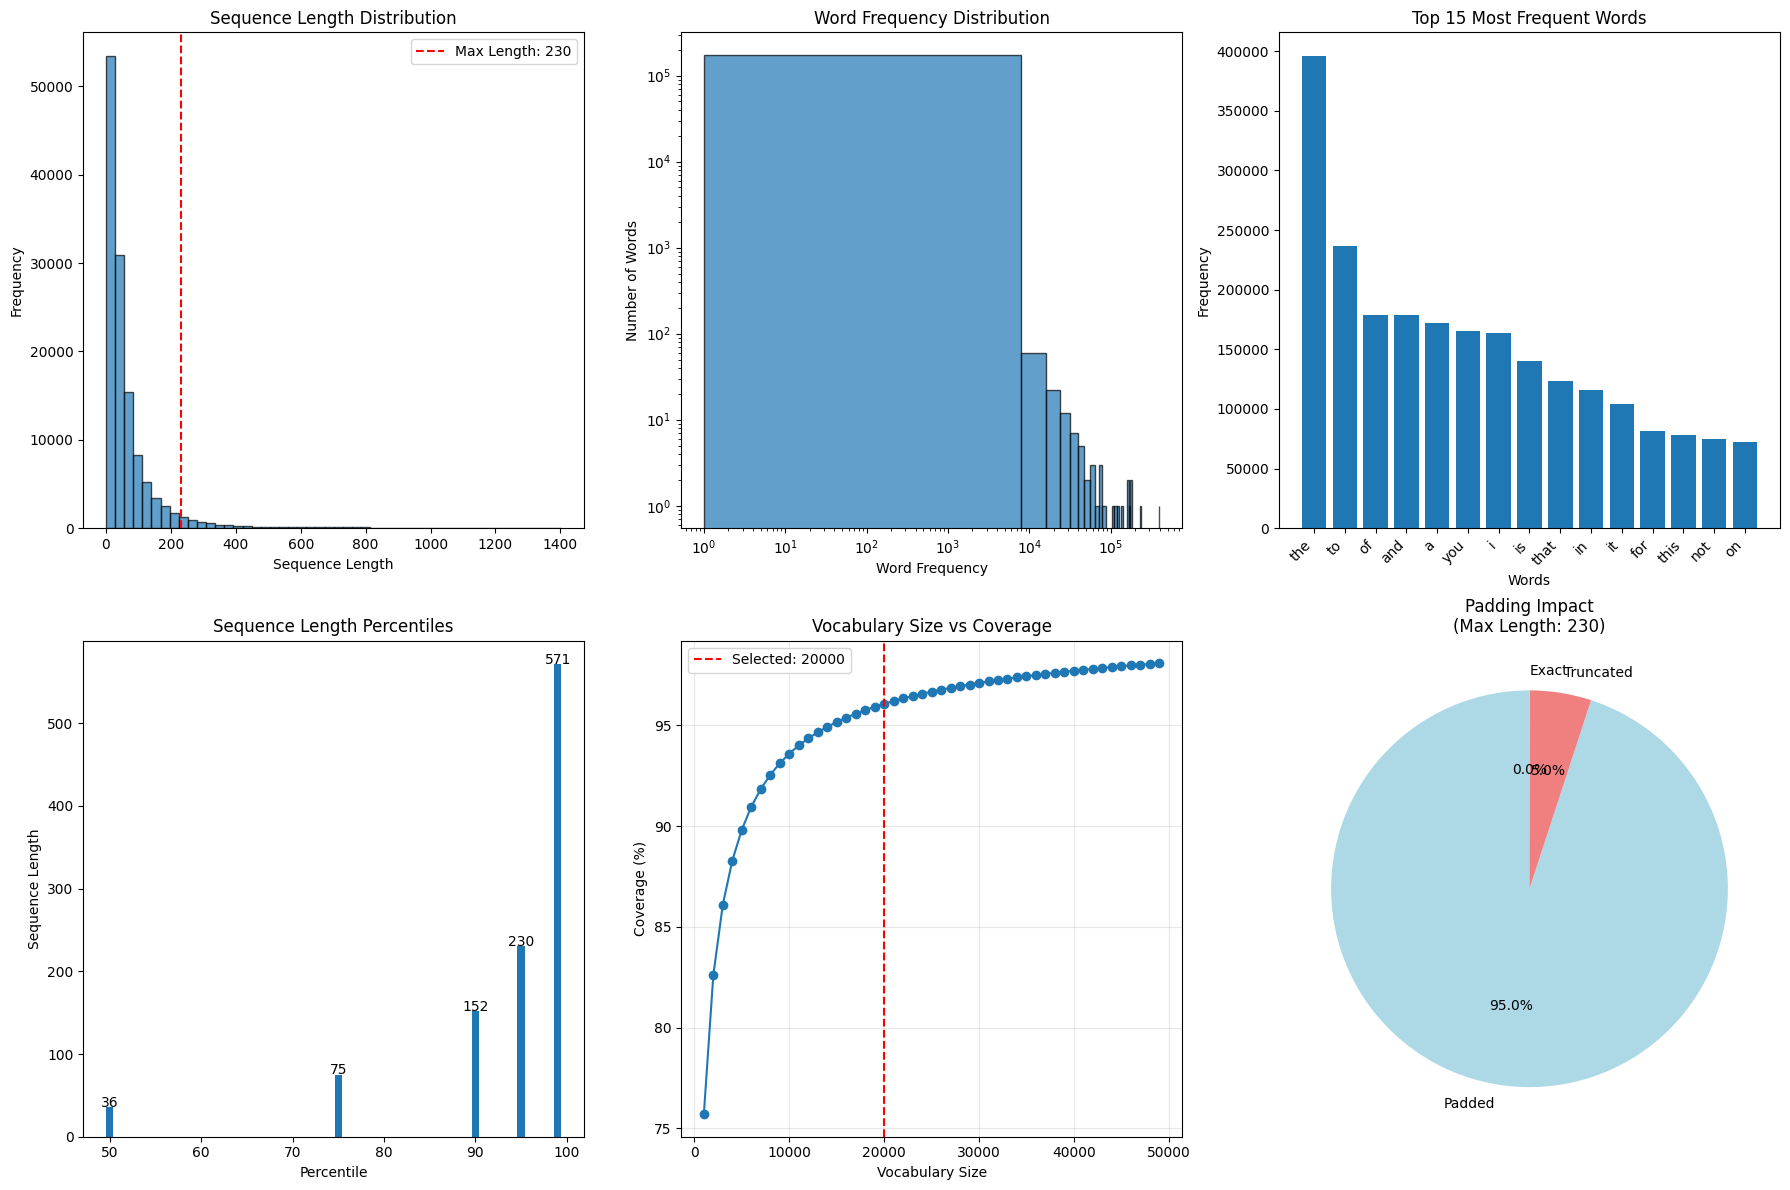


TOKENIZATION DEMONSTRATION

Example 1:
Original text: drop dead and accept facebook pages deeside college is a mother fucking spunk dunk pottery which is ...
Converting 1 texts to sequences...
✓ Conversion completed!
Token sequence: [1629, 1070, 5, 833, 2997, 119, 1, 1160, 9, 6, 1116, 358, 1, 1, 11615, 54, 9, 1575, 35, 94]...
Sequence length: 43

Padding sequences to length 230...
✓ Padded sequences shape: (1, 230)
Padding statistics:
- Truncated sequences: 0 (0.00%)
- Padded sequences: 1 (100.00%)
- Exact length sequences: 0 (0.00%)
Padded shape: (230,)
First 20 tokens: [ 1629  1070     5   833  2997   119     1  1160     9     6  1116   358
     1     1 11615    54     9  1575    35    94]
Last 20 tokens: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Decoded (first 50 tokens): drop dead and accept facebook pages <OOV> college is a mother fucking <OOV> <OOV> pottery which is held at user <OOV> com and likes to suck georg <OOV> of and doesn't accept facebook groups like the official faceb

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

print("TensorFlow version:", tf.__version__)


def load_and_preprocess_data():
    """Load and quickly preprocess the data if not already done"""
    print("Loading and preprocessing data...")

    # Load data
    TRAIN_FILE = f"{dataset_base_path}train.csv"
    TEST_FILE = f"{dataset_base_path}test.csv"

    train_df = pd.read_csv(TRAIN_FILE)
    test_df = pd.read_csv(TEST_FILE)

    # print(f"✓ Training data loaded: {train_df.shape}")
    # print(f"✓ Test data loaded: {test_df.shape}")

    # Quick text cleaning
    def clean_text(text):
        if pd.isna(text):
            return ""
        text = text.lower()
        text = re.sub(r'[\n\t]', ' ', text)
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        text = re.sub(r'@\w+|#\w+', '', text)
        text = re.sub(r'\s+', ' ', text)
        text = text.strip()
        return text

    # Clean text
    train_df['cleaned_text'] = train_df['comment_text'].apply(clean_text)
    test_df['cleaned_text'] = test_df['comment_text'].apply(clean_text)

    # Remove empty texts
    train_df = train_df[train_df['cleaned_text'].str.len() > 0]
    test_df = test_df[test_df['cleaned_text'].str.len() > 0]

    # Create train-validation split
    X = train_df['cleaned_text']
    y = train_df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]

    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=train_df['toxic']
    )

    # print(f"✓ Train-validation split created")
    # print(f"  - Training: {len(X_train):,} samples")
    # print(f"  - Validation: {len(X_val):,} samples")
    # print(f"  - Test: {len(test_df):,} samples")

    return X_train, X_val, y_train, y_val, test_df


class TokenizationConfig:
    """Configuration class for tokenization parameters"""
    def __init__(self):
        # Vocabulary settings
        self.MAX_VOCAB_SIZE = 20000  # Top 20k most frequent words
        self.MAX_SEQUENCE_LENGTH = None  # Will be set based on data analysis
        self.OOV_TOKEN = "<OOV>"  # Out-of-vocabulary token

        # Tokenizer settings
        self.LOWER = True  # Convert to lowercase
        self.SPLIT = ' '   # Split on spaces
        self.CHAR_LEVEL = False  # Word-level tokenization
        self.FILTERS = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'  # Characters to filter out

        # Padding settings
        self.PADDING_TYPE = 'post'  # Pad at the end
        self.TRUNCATING_TYPE = 'post'  # Truncate at the end
        self.PAD_VALUE = 0  # Value to use for padding


class TextTokenizer:
    """Advanced text tokenizer with additional features"""

    def __init__(self, config):
        self.config = config
        self.tokenizer = None
        self.vocab_size = None
        self.word_index = None
        self.reverse_word_index = None

    def create_tokenizer(self, texts):
        """Create and fit tokenizer on texts"""
        print("="*50)
        print("CREATING TOKENIZER")
        print("="*50)

        # Initialize tokenizer
        self.tokenizer = Tokenizer(
            num_words=self.config.MAX_VOCAB_SIZE,
            oov_token=self.config.OOV_TOKEN,
            lower=self.config.LOWER,
            split=self.config.SPLIT,
            char_level=self.config.CHAR_LEVEL,
            filters=self.config.FILTERS
        )

        # Fit tokenizer on texts
        print(f"Fitting tokenizer on {len(texts):,} texts...")
        self.tokenizer.fit_on_texts(texts)

        # Get vocabulary info
        self.word_index = self.tokenizer.word_index
        self.vocab_size = min(len(self.word_index) + 1, self.config.MAX_VOCAB_SIZE)
        self.reverse_word_index = {v: k for k, v in self.word_index.items()}

        print(f"Tokenizer created successfully!")
        print(f"Total unique words found: {len(self.word_index):,}")
        print(f"Vocabulary size (after limit): {self.vocab_size:,}")
        print(f"OOV token index: {self.word_index.get(self.config.OOV_TOKEN, 'Not found')}")

        return self.tokenizer

    def texts_to_sequences(self, texts):
        """Convert texts to sequences of integers"""
        if self.tokenizer is None:
            raise ValueError("Tokenizer not created yet. Call create_tokenizer first.")

        print(f"Converting {len(texts):,} texts to sequences...")
        sequences = self.tokenizer.texts_to_sequences(texts)
        print(f"✓ Conversion completed!")

        return sequences

    def analyze_sequences(self, sequences):
        """Analyze sequence statistics"""
        print("\n" + "="*50)
        print("SEQUENCE ANALYSIS")
        print("="*50)

        # Calculate sequence lengths
        seq_lengths = [len(seq) for seq in sequences]

        print(f"Sequence statistics:")
        print(f"Mean length: {np.mean(seq_lengths):.2f}")
        print(f"Median length: {np.median(seq_lengths):.2f}")
        print(f"Std deviation: {np.std(seq_lengths):.2f}")
        print(f"Min length: {min(seq_lengths)}")
        print(f"Max length: {max(seq_lengths)}")
        print()

        # Percentiles
        percentiles = [50, 75, 90, 95, 99]
        print("Length percentiles:")
        for p in percentiles:
            val = np.percentile(seq_lengths, p)
            print(f"{p}th percentile: {val:.0f}")
        print()

        # Recommend sequence length
        recommended_length = int(np.percentile(seq_lengths, 95))
        print(f"Recommended MAX_SEQUENCE_LENGTH: {recommended_length}")

        return seq_lengths, recommended_length

    def pad_sequences(self, sequences, max_length=None):
        """Pad sequences to uniform length"""
        if max_length is None:
            max_length = self.config.MAX_SEQUENCE_LENGTH

        print(f"\nPadding sequences to length {max_length}...")

        padded_sequences = pad_sequences(
            sequences,
            maxlen=max_length,
            padding=self.config.PADDING_TYPE,
            truncating=self.config.TRUNCATING_TYPE,
            value=self.config.PAD_VALUE
        )

        print(f"Padded sequences shape: {padded_sequences.shape}")

        # Calculate padding statistics
        original_lengths = [len(seq) for seq in sequences]
        truncated = sum(1 for length in original_lengths if length > max_length)
        padded = sum(1 for length in original_lengths if length < max_length)
        exact = len(sequences) - truncated - padded

        print(f"Padding statistics:")
        print(f"- Truncated sequences: {truncated:,} ({truncated/len(sequences)*100:.2f}%)")
        print(f"- Padded sequences: {padded:,} ({padded/len(sequences)*100:.2f}%)")
        print(f"- Exact length sequences: {exact:,} ({exact/len(sequences)*100:.2f}%)")

        return padded_sequences

    def decode_sequence(self, sequence):
        """Decode a sequence back to text"""
        words = []
        for idx in sequence:
            if idx == 0:  # Padding
                words.append('<PAD>')
            elif idx in self.reverse_word_index:
                words.append(self.reverse_word_index[idx])
            else:
                words.append('<UNK>')
        return ' '.join(words)

    def get_vocabulary_stats(self):
        """Get detailed vocabulary statistics"""
        print("\n" + "="*50)
        print("VOCABULARY STATISTICS")
        print("="*50)

        word_counts = self.tokenizer.word_counts
        word_docs = self.tokenizer.word_docs

        # Most common words
        print("Top 20 most frequent words:")
        most_common = Counter(word_counts).most_common(20)
        for i, (word, count) in enumerate(most_common, 1):
            print(f"{i:2}. {word:15} - {count:,} occurrences")
        print()

        # Frequency distribution
        freq_counts = Counter(word_counts.values())
        print("Frequency distribution (top 10):")
        for freq, count in sorted(freq_counts.items(), reverse=True)[:10]:
            print(f"Words appearing {freq:,} times: {count:,} words")

        return word_counts, word_docs



def plot_tokenization_analysis(text_tokenizer, train_sequences, config):
    """Create visualizations for tokenization analysis"""

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # 1. Sequence length distribution
    seq_lengths = [len(seq) for seq in train_sequences]
    axes[0, 0].hist(seq_lengths, bins=50, alpha=0.7, edgecolor='black')
    axes[0, 0].axvline(config.MAX_SEQUENCE_LENGTH, color='red', linestyle='--',
                      label=f'Max Length: {config.MAX_SEQUENCE_LENGTH}')
    axes[0, 0].set_title('Sequence Length Distribution')
    axes[0, 0].set_xlabel('Sequence Length')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].legend()

    # 2. Vocabulary frequency distribution
    word_counts = text_tokenizer.tokenizer.word_counts
    freq_values = list(word_counts.values())
    axes[0, 1].hist(freq_values, bins=50, alpha=0.7, edgecolor='black')
    axes[0, 1].set_title('Word Frequency Distribution')
    axes[0, 1].set_xlabel('Word Frequency')
    axes[0, 1].set_ylabel('Number of Words')
    axes[0, 1].set_yscale('log')
    axes[0, 1].set_xscale('log')

    # 3. Top words bar chart
    most_common = Counter(word_counts).most_common(15)
    words, counts = zip(*most_common)
    axes[0, 2].bar(range(len(words)), counts)
    axes[0, 2].set_title('Top 15 Most Frequent Words')
    axes[0, 2].set_xlabel('Words')
    axes[0, 2].set_ylabel('Frequency')
    axes[0, 2].set_xticks(range(len(words)))
    axes[0, 2].set_xticklabels(words, rotation=45, ha='right')

    # 4. Sequence length percentiles
    percentiles = [50, 75, 90, 95, 99]
    perc_values = [np.percentile(seq_lengths, p) for p in percentiles]
    axes[1, 0].bar(percentiles, perc_values)
    axes[1, 0].set_title('Sequence Length Percentiles')
    axes[1, 0].set_xlabel('Percentile')
    axes[1, 0].set_ylabel('Sequence Length')
    for i, v in enumerate(perc_values):
        axes[1, 0].text(percentiles[i], v + 0.5, f'{v:.0f}', ha='center')

    # 5. Vocabulary size vs coverage
    sorted_counts = sorted(word_counts.values(), reverse=True)
    cumsum_counts = np.cumsum(sorted_counts)
    total_words = cumsum_counts[-1]
    coverage = cumsum_counts / total_words * 100

    vocab_sizes = range(1000, min(len(sorted_counts), 50000), 1000)
    coverages = [coverage[min(i-1, len(coverage)-1)] for i in vocab_sizes]

    axes[1, 1].plot(vocab_sizes, coverages, marker='o')
    axes[1, 1].axvline(config.MAX_VOCAB_SIZE, color='red', linestyle='--',
                      label=f'Selected: {config.MAX_VOCAB_SIZE}')
    axes[1, 1].set_title('Vocabulary Size vs Coverage')
    axes[1, 1].set_xlabel('Vocabulary Size')
    axes[1, 1].set_ylabel('Coverage (%)')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    # 6. Padding impact visualization
    original_lengths = seq_lengths
    max_len = config.MAX_SEQUENCE_LENGTH

    padded_count = sum(1 for length in original_lengths if length < max_len)
    truncated_count = sum(1 for length in original_lengths if length > max_len)
    exact_count = len(original_lengths) - padded_count - truncated_count

    labels = ['Padded', 'Truncated', 'Exact']
    sizes = [padded_count, truncated_count, exact_count]
    colors = ['lightblue', 'lightcoral', 'lightgreen']

    axes[1, 2].pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    axes[1, 2].set_title(f'Padding Impact\n(Max Length: {max_len})')

    plt.tight_layout()
    plt.show()



def demonstrate_tokenization(text_tokenizer, sample_texts, max_length):
    """Demonstrate tokenization process with examples"""
    print("\n" + "="*50)
    print("TOKENIZATION DEMONSTRATION")
    print("="*50)

    for i, text in enumerate(sample_texts[:3]):
        print(f"\nExample {i+1}:")
        print(f"Original text: {text[:100]}...")

        # Convert to sequence
        sequence = text_tokenizer.texts_to_sequences([text])[0]
        print(f"Token sequence: {sequence[:20]}..." if len(sequence) > 20 else f"Token sequence: {sequence}")
        print(f"Sequence length: {len(sequence)}")

        # Pad sequence
        padded = text_tokenizer.pad_sequences([sequence], max_length)[0]
        print(f"Padded shape: {padded.shape}")
        print(f"First 20 tokens: {padded[:20]}")
        print(f"Last 20 tokens: {padded[-20:]}")

        # Decode back
        decoded = text_tokenizer.decode_sequence(sequence[:50])  # First 50 tokens
        print(f"Decoded (first 50 tokens): {decoded}")
        print("-" * 50)



def complete_tokenization_pipeline(X_train, X_val, test_processed,
                                 y_train=None, y_val=None,
                                 vocab_size=20000):
    """Complete tokenization pipeline"""
    print("="*60)
    print("STARTING TOKENIZATION PIPELINE")
    print("="*60)

    # Initialize config
    config = TokenizationConfig()
    config.MAX_VOCAB_SIZE = vocab_size

    # Initialize tokenizer
    text_tokenizer = TextTokenizer(config)

    # Create tokenizer using training data only
    tokenizer = text_tokenizer.create_tokenizer(X_train)

    # Get vocabulary statistics
    word_counts, word_docs = text_tokenizer.get_vocabulary_stats()

    # Convert training data to sequences
    print("\n" + "="*50)
    print("PROCESSING TRAINING DATA")
    print("="*50)
    train_sequences = text_tokenizer.texts_to_sequences(X_train)

    # Analyze sequences and get recommended length
    train_lengths, recommended_length = text_tokenizer.analyze_sequences(train_sequences)

    # Set the recommended sequence length
    config.MAX_SEQUENCE_LENGTH = recommended_length

    # Pad training sequences
    X_train_padded = text_tokenizer.pad_sequences(train_sequences, recommended_length)

    # Process validation data
    print("\n" + "="*50)
    print("PROCESSING VALIDATION DATA")
    print("="*50)
    val_sequences = text_tokenizer.texts_to_sequences(X_val)
    X_val_padded = text_tokenizer.pad_sequences(val_sequences, recommended_length)

    # Process test data
    print("\n" + "="*50)
    print("PROCESSING TEST DATA")
    print("="*50)
    test_sequences = text_tokenizer.texts_to_sequences(test_processed['cleaned_text'])
    X_test_padded = text_tokenizer.pad_sequences(test_sequences, recommended_length)

    # Create visualizations
    print("\n" + "="*50)
    print("CREATING VISUALIZATIONS")
    print("="*50)
    plot_tokenization_analysis(text_tokenizer, train_sequences, config)

    # Demonstrate with examples
    sample_texts = X_train.iloc[:3].tolist() if hasattr(X_train, 'iloc') else list(X_train)[:3]
    demonstrate_tokenization(text_tokenizer, sample_texts, config.MAX_SEQUENCE_LENGTH)

    # Print final summary
    print("\n" + "="*60)
    print("TOKENIZATION PIPELINE COMPLETE!")
    print("="*60)
    print(f"Vocabulary size: {text_tokenizer.vocab_size:,}")
    print(f"Max sequence length: {config.MAX_SEQUENCE_LENGTH}")
    print(f"Training data shape: {X_train_padded.shape}")
    print(f"Validation data shape: {X_val_padded.shape}")
    print(f"Test data shape: {X_test_padded.shape}")

    # Return everything in a dictionary
    return {
        'tokenizer': text_tokenizer,
        'X_train_padded': X_train_padded,
        'X_val_padded': X_val_padded,
        'X_test_padded': X_test_padded,
        'y_train': y_train,
        'y_val': y_val,
        'config': config,
        'vocab_size': text_tokenizer.vocab_size,
        'max_length': config.MAX_SEQUENCE_LENGTH,
        'train_sequences': train_sequences,
        'val_sequences': val_sequences,
        'test_sequences': test_sequences
    }



print("="*60)
print("STARTING COMPLETE TOKENIZATION PROCESS")
print("="*60)

# Step 1: Load and preprocess data
X_train, X_val, y_train, y_val, test_processed = load_and_preprocess_data()

# Step 2: Run tokenization pipeline
tokenized_data = complete_tokenization_pipeline(
    X_train=X_train,
    X_val=X_val,
    test_processed=test_processed,
    y_train=y_train,
    y_val=y_val,
    vocab_size=20000
)

# Step 3: Extract results
X_train_tokens = tokenized_data['X_train_padded']
X_val_tokens = tokenized_data['X_val_padded']
X_test_tokens = tokenized_data['X_test_padded']
tokenizer_obj = tokenized_data['tokenizer']
vocab_size = tokenized_data['vocab_size']
max_length = tokenized_data['max_length']

# Step 4: Final summary
print("\n" + "="*60)
print("TOKENIZATION COMPLETE! READY FOR MODEL TRAINING")
print("="*60)
print(f"Training tokens shape: {X_train_tokens.shape}")
print(f"Validation tokens shape: {X_val_tokens.shape}")
print(f"Test tokens shape: {X_test_tokens.shape}")
print(f"Vocabulary size: {vocab_size:,}")
print(f"Max sequence length: {max_length}")
print(f"Training labels shape: {y_train.shape}")
print(f"Validation labels shape: {y_val.shape}")

print(f"\nSAMPLE TOKENIZED DATA:")
print(f"First training sample: {X_train_tokens[0][:30]}...")
print(f"Sample labels: {y_train.iloc[0].values}")

print(f"\nEXAMPLE TEXT VS TOKENS:")
sample_text = X_train.iloc[0]
print(f"Original: {sample_text[:150]}...")
decoded = tokenizer_obj.decode_sequence(X_train_tokens[0][:50])
print(f"Tokenized & decoded: {decoded}")

print(f"\nVariables ready for model training:")
print(f"   - X_train_tokens: Training data")
print(f"   - X_val_tokens: Validation data")
print(f"   - X_test_tokens: Test data")
print(f"   - y_train, y_val: Labels")
print(f"   - vocab_size: {vocab_size}")
print(f"   - max_length: {max_length}")

TensorFlow version: 2.19.0
GPU available: []
Found existing tokenized data!
Training data shape: (127651, 230)
Validation data shape: (31913, 230)
Vocabulary size: 20000
Max sequence length: 230

Starting training with existing data...
Model Configuration:
Embedding dimension: 128
GRU units: 64
Dense units: 32
Dropout rate: 0.3
Batch size: 128
Max epochs: 5
Learning rate: 0.001
BUILDING LIGHTWEIGHT GRU MODEL


Model: "lightweight_gru"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 230)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 230, 128)  │  2,560,000 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d   │ (None, 230, 128)  │          0 │ embedding[0][0]   │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_gru   │ (None, 230, 128)  │     74,496 │ spatial_dropout1… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ bidirectional_gr… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ bidirectional_gr… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 256)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256)       │      1,024 │ concatenate[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hidden_dense        │ (None, 32)        │      8,224 │ batch_normalizat… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 32)        │          0 │ hidden_dense[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 6)         │        198 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,643,942 (10.09 MB)

 Trainable params: 2,643,430 (10.08 MB)

 Non-trainable params: 512 (2.00 KB)


Model Parameters:
Total parameters: 2,643,942
Trainable parameters: 2,643,430
Model size estimate: ~10.09 MB
Model compiled with binary_crossentropy loss and Adam optimizer
Learning rate: 0.001
✓ Callbacks configured. Experiment directory: experiments/lightweight_gru_20251207_081306

STARTING TRAINING
Epoch 1/5
998/998 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4897 - auc: 0.8265 - loss: 0.2246 - precision: 0.2899 - recall: 0.4466
Epoch 1: val_auc improved from -inf to 0.98219, saving model to experiments/lightweight_gru_20251207_081306/checkpoints/best_model.h5


998/998 ━━━━━━━━━━━━━━━━━━━━ 1149s 1s/step - accuracy: 0.4899 - auc: 0.8266 - loss: 0.2245 - precision: 0.2900 - recall: 0.4467 - val_accuracy: 0.9938 - val_auc: 0.9822 - val_loss: 0.0591 - val_precision: 0.7792 - val_recall: 0.7044 - learning_rate: 0.0010
Epoch 2/5
998/998 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9108 - auc: 0.9808 - loss: 0.0581 - precision: 0.8133 - recall: 0.6695
Epoch 2: val_auc improved from 0.98219 to 0.98526, saving model to experiments/lightweight_gru_20251207_081306/checkpoints/best_model.h5


998/998 ━━━━━━━━━━━━━━━━━━━━ 1114s 1s/step - accuracy: 0.9108 - auc: 0.9808 - loss: 0.0581 - precision: 0.8133 - recall: 0.6695 - val_accuracy: 0.9935 - val_auc: 0.9853 - val_loss: 0.0521 - val_precision: 0.7939 - val_recall: 0.7126 - learning_rate: 0.0010
Epoch 3/5
998/998 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9299 - auc: 0.9866 - loss: 0.0480 - precision: 0.8294 - recall: 0.6923
Epoch 3: val_auc did not improve from 0.98526
998/998 ━━━━━━━━━━━━━━━━━━━━ 1172s 1s/step - accuracy: 0.9299 - auc: 0.9866 - loss: 0.0480 - precision: 0.8294 - recall: 0.6923 - val_accuracy: 0.9937 - val_auc: 0.9809 - val_loss: 0.0498 - val_precision: 0.8365 - val_recall: 0.6794 - learning_rate: 0.0010
Epoch 4/5
998/998 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9052 - auc: 0.9891 - loss: 0.0435 - precision: 0.8308 - recall: 0.7219
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 4: val_auc did not improve from 0.98526
998/998 ━━━━━━━━━━━━━━━━━━━━ 1131s 1s/step - ac

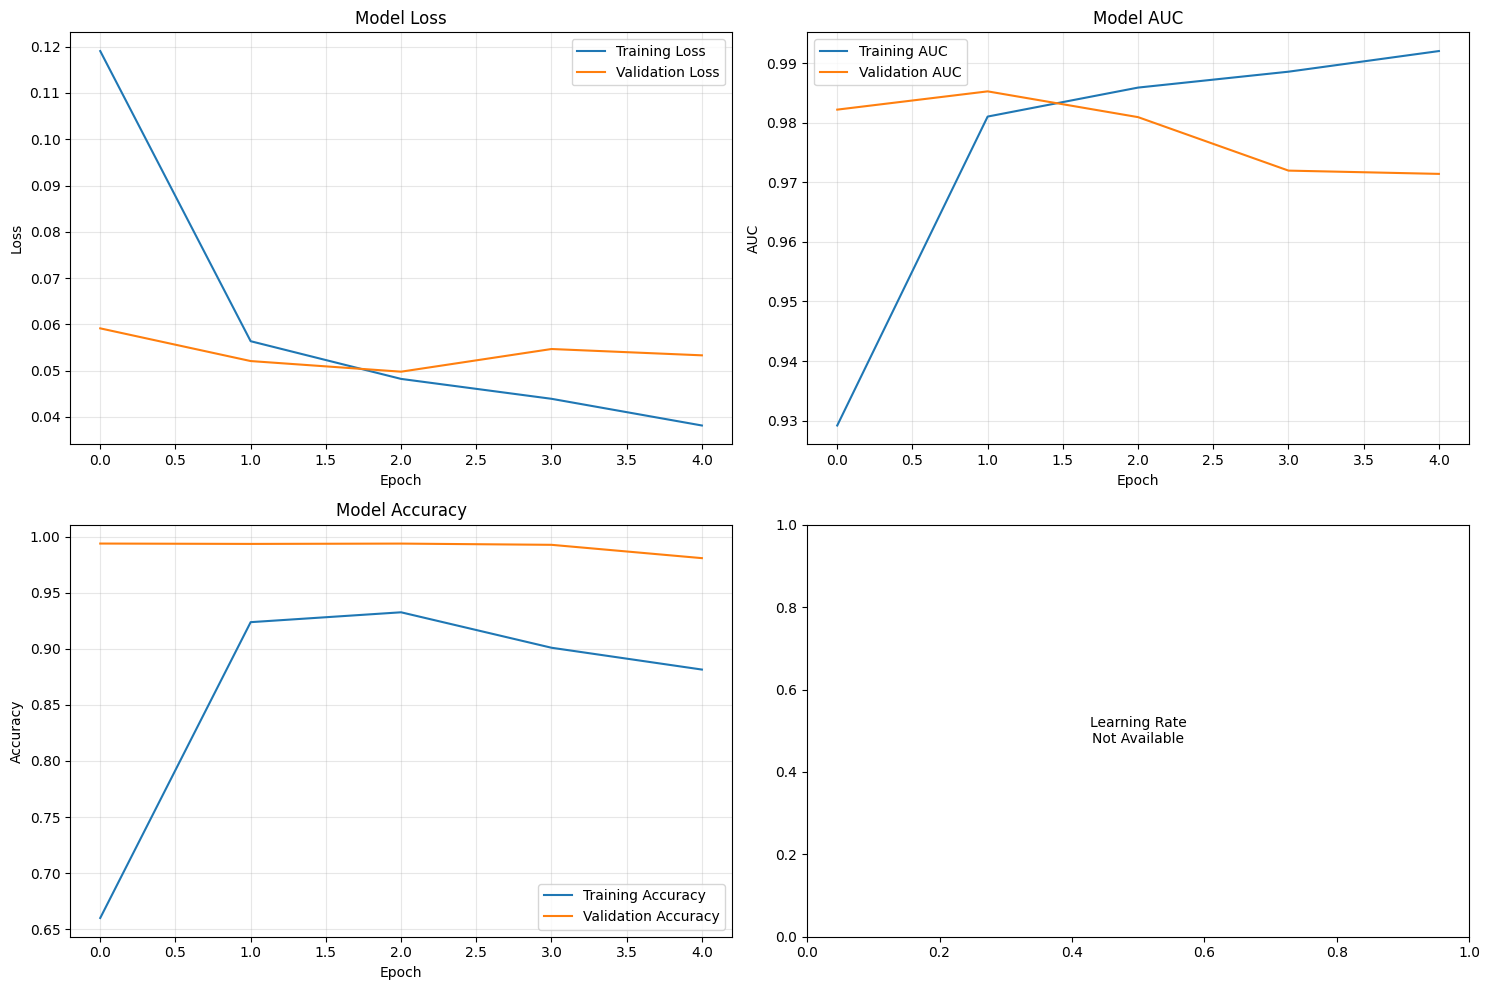

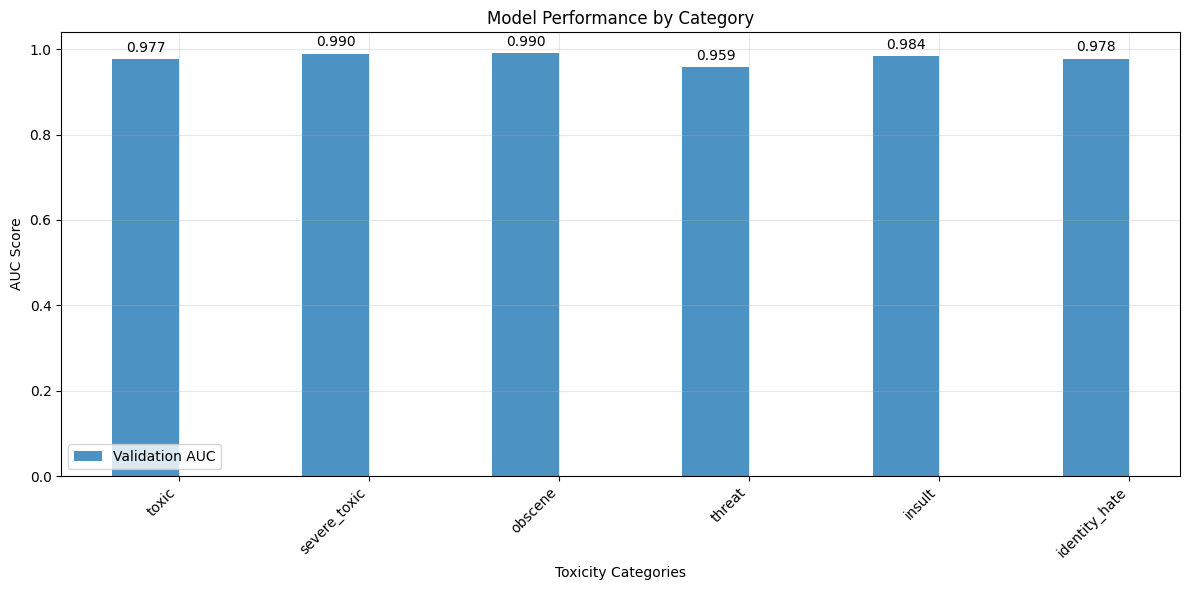


TRAINING PIPELINE COMPLETE!
Model saved: experiments/lightweight_gru_20251207_081306/final_model.h5
Experiment directory: experiments/lightweight_gru_20251207_081306
Training duration: 1:34:27.106708
Validation AUC: 0.9797

TRAINING COMPLETED SUCCESSFULLY!
RESULTS SUMMARY:
Model trained and saved in: experiments/lightweight_gru_20251207_081306
Training duration: 1:34:27.106708

VALIDATION PERFORMANCE:
   toxic          : AUC = 0.9773
   severe_toxic   : AUC = 0.9896
   obscene        : AUC = 0.9902
   threat         : AUC = 0.9586
   insult         : AUC = 0.9842
   identity_hate  : AUC = 0.9782

Average AUC: 0.9797

MODEL INFO:
   Total parameters: 2,643,942
   Model size: ~10.09 MB

SAVED FILES:
   - Best model: experiments/lightweight_gru_20251207_081306/checkpoints/best_model.h5
   - Final model: experiments/lightweight_gru_20251207_081306/final_model.h5
   - Training log: experiments/lightweight_gru_20251207_081306/logs/training_log.csv
   - Visualizations: experiments/lightweigh

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Input, Embedding, GRU, Dense, Dropout, BatchNormalization,
    GlobalMaxPooling1D, GlobalAveragePooling1D, Concatenate,
    SpatialDropout1D, Bidirectional
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (
    EarlyStopping, ReduceLROnPlateau, ModelCheckpoint,
    TensorBoard, CSVLogger
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import AUC, Precision, Recall
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
import os
import datetime
import warnings
warnings.filterwarnings('ignore')

print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

class GRUModelConfig:
    """Configuration for lightweight GRU model"""
    def __init__(self):
        # Model architecture
        self.EMBEDDING_DIM = 128        # Lightweight embedding dimension
        self.GRU_UNITS = 64            # GRU hidden units (lightweight)
        self.DENSE_UNITS = 32          # Dense layer units
        self.NUM_CLASSES = 6           # 6 toxicity categories

        # Regularization
        self.DROPOUT_RATE = 0.3        # Dropout rate
        self.SPATIAL_DROPOUT = 0.2     # Spatial dropout for embeddings
        self.L2_REG = 1e-4            # L2 regularization
        self.RECURRENT_DROPOUT = 0.2   # GRU recurrent dropout

        # Training parameters
        self.BATCH_SIZE = 128          # Batch size for training
        self.EPOCHS = 5               # Maximum epochs
        self.LEARNING_RATE = 0.001     # Initial learning rate
        self.VALIDATION_SPLIT = 0.2    # If no validation data provided

        # Early stopping and scheduling
        self.PATIENCE = 5              # Early stopping patience
        self.FACTOR = 0.5              # Learning rate reduction factor
        self.MIN_LR = 1e-6            # Minimum learning rate

        # Model saving
        self.SAVE_BEST_ONLY = True
        self.MONITOR_METRIC = 'val_auc'
        self.MODE = 'max'

class LightweightGRUModel:
    """Lightweight GRU model for toxic comment classification"""

    def __init__(self, config, vocab_size, max_length):
        self.config = config
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.model = None
        self.history = None

    def build_model(self, use_bidirectional=True, use_pooling_concat=True):
        """Build lightweight GRU model"""
        print("="*50)
        print("BUILDING LIGHTWEIGHT GRU MODEL")
        print("="*50)

        # Input layer
        input_text = Input(shape=(self.max_length,), name='text_input')

        # Embedding layer with spatial dropout
        embedding = Embedding(
            input_dim=self.vocab_size,
            output_dim=self.config.EMBEDDING_DIM,
            input_length=self.max_length,
            trainable=True,
            name='embedding'
        )(input_text)

        # Spatial dropout to prevent overfitting in embeddings
        embedding = SpatialDropout1D(self.config.SPATIAL_DROPOUT)(embedding)

        # GRU layer (bidirectional or unidirectional)
        if use_bidirectional:
            gru = Bidirectional(
                GRU(
                    self.config.GRU_UNITS,
                    dropout=self.config.DROPOUT_RATE,
                    recurrent_dropout=self.config.RECURRENT_DROPOUT,
                    return_sequences=True,
                    kernel_regularizer=l2(self.config.L2_REG),
                    name='gru'
                ),
                name='bidirectional_gru'
            )(embedding)
        else:
            gru = GRU(
                self.config.GRU_UNITS,
                dropout=self.config.DROPOUT_RATE,
                recurrent_dropout=self.config.RECURRENT_DROPOUT,
                return_sequences=True,
                kernel_regularizer=l2(self.config.L2_REG),
                name='gru'
            )(embedding)

        # Global pooling (concatenate max and average pooling for better representation)
        if use_pooling_concat:
            max_pool = GlobalMaxPooling1D()(gru)
            avg_pool = GlobalAveragePooling1D()(gru)
            pooled = Concatenate()([max_pool, avg_pool])
        else:
            pooled = GlobalMaxPooling1D()(gru)

        # Batch normalization
        normalized = BatchNormalization()(pooled)

        # Dense hidden layer
        hidden = Dense(
            self.config.DENSE_UNITS,
            activation='relu',
            kernel_regularizer=l2(self.config.L2_REG),
            name='hidden_dense'
        )(normalized)

        # Dropout
        hidden = Dropout(self.config.DROPOUT_RATE)(hidden)

        # Output layer (6 toxicity categories)
        output = Dense(
            self.config.NUM_CLASSES,
            activation='sigmoid',
            name='output'
        )(hidden)

        # Create model
        self.model = Model(inputs=input_text, outputs=output, name='lightweight_gru')

        # Model summary
        self.model.summary()

        # Calculate model parameters
        total_params = self.model.count_params()
        trainable_params = sum([tf.keras.backend.count_params(w) for w in self.model.trainable_weights])

        print(f"\nModel Parameters:")
        print(f"Total parameters: {total_params:,}")
        print(f"Trainable parameters: {trainable_params:,}")
        print(f"Model size estimate: ~{total_params * 4 / 1024 / 1024:.2f} MB")

        return self.model

    def compile_model(self, optimizer=None, loss='binary_crossentropy'):
        """Compile the model with optimizer and metrics"""
        if optimizer is None:
            optimizer = Adam(learning_rate=self.config.LEARNING_RATE)

        # Custom metrics for multi-label classification
        metrics = [
            'accuracy',
            AUC(name='auc'),
            Precision(name='precision'),
            Recall(name='recall')
        ]

        self.model.compile(
            optimizer=optimizer,
            loss=loss,
            metrics=metrics
        )

        print(f"Model compiled with {loss} loss and Adam optimizer")
        print(f"Learning rate: {self.config.LEARNING_RATE}")
        return self.model


class TrainingManager:
    """Manage training process with callbacks and monitoring"""

    def __init__(self, config, model_name="lightweight_gru"):
        self.config = config
        self.model_name = model_name
        self.timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        self.experiment_dir = f"experiments/{model_name}_{self.timestamp}"

        # Create experiment directory
        os.makedirs(self.experiment_dir, exist_ok=True)
        os.makedirs(f"{self.experiment_dir}/checkpoints", exist_ok=True)
        os.makedirs(f"{self.experiment_dir}/logs", exist_ok=True)

    def get_callbacks(self):
        """Get training callbacks"""
        callbacks = []

        # Early stopping
        early_stopping = EarlyStopping(
            monitor=self.config.MONITOR_METRIC,
            patience=self.config.PATIENCE,
            mode=self.config.MODE,
            restore_best_weights=True,
            verbose=1
        )
        callbacks.append(early_stopping)

        # Learning rate reduction
        lr_reducer = ReduceLROnPlateau(
            monitor=self.config.MONITOR_METRIC,
            factor=self.config.FACTOR,
            patience=self.config.PATIENCE // 2,
            mode=self.config.MODE,
            min_lr=self.config.MIN_LR,
            verbose=1
        )
        callbacks.append(lr_reducer)

        # Model checkpointing
        checkpoint_path = f"{self.experiment_dir}/checkpoints/best_model.h5"
        model_checkpoint = ModelCheckpoint(
            filepath=checkpoint_path,
            monitor=self.config.MONITOR_METRIC,
            mode=self.config.MODE,
            save_best_only=self.config.SAVE_BEST_ONLY,
            save_weights_only=False,
            verbose=1
        )
        callbacks.append(model_checkpoint)

        # CSV logging
        csv_logger = CSVLogger(
            filename=f"{self.experiment_dir}/logs/training_log.csv",
            append=True
        )
        callbacks.append(csv_logger)

        # TensorBoard (optional)
        try:
            tensorboard = TensorBoard(
                log_dir=f"{self.experiment_dir}/logs/tensorboard",
                histogram_freq=1,
                write_graph=True,
                update_freq='epoch'
            )
            callbacks.append(tensorboard)
        except:
            print("TensorBoard callback skipped")

        print(f"Callbacks configured. Experiment directory: {self.experiment_dir}")
        return callbacks


class ModelEvaluator:
    """Evaluate model performance and create visualizations"""

    def __init__(self, model, label_names):
        self.model = model
        self.label_names = label_names

    def evaluate_model(self, X_val, y_val, X_test=None, y_test=None):
        """Comprehensive model evaluation"""
        print("="*50)
        print("MODEL EVALUATION")
        print("="*50)

        # Predictions on validation set
        print("Evaluating on validation set...")
        val_predictions = self.model.predict(X_val, verbose=1)
        val_predictions_binary = (val_predictions > 0.5).astype(int)

        # Calculate metrics for each label
        val_results = {}
        for i, label in enumerate(self.label_names):
            auc = roc_auc_score(y_val.iloc[:, i], val_predictions[:, i])
            val_results[label] = {
                'auc': auc,
                'predictions': val_predictions[:, i],
                'binary_predictions': val_predictions_binary[:, i]
            }

        # Overall validation metrics
        overall_val_auc = np.mean([val_results[label]['auc'] for label in self.label_names])
        print(f"\nValidation Results:")
        print(f"Overall AUC: {overall_val_auc:.4f}")

        for label in self.label_names:
            print(f"{label:15}: AUC = {val_results[label]['auc']:.4f}")

        # Test set evaluation (if provided)
        test_results = None
        if X_test is not None and y_test is not None:
            print(f"\nEvaluating on test set...")
            test_predictions = self.model.predict(X_test, verbose=1)
            test_predictions_binary = (test_predictions > 0.5).astype(int)

            test_results = {}
            for i, label in enumerate(self.label_names):
                auc = roc_auc_score(y_test.iloc[:, i], test_predictions[:, i])
                test_results[label] = {
                    'auc': auc,
                    'predictions': test_predictions[:, i],
                    'binary_predictions': test_predictions_binary[:, i]
                }

            overall_test_auc = np.mean([test_results[label]['auc'] for label in self.label_names])
            print(f"\nTest Results:")
            print(f"Overall AUC: {overall_test_auc:.4f}")

            for label in self.label_names:
                print(f"{label:15}: AUC = {test_results[label]['auc']:.4f}")

        return val_results, test_results

    def plot_training_history(self, history, save_path=None):
        """Plot training history"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        # Loss
        axes[0, 0].plot(history.history['loss'], label='Training Loss')
        axes[0, 0].plot(history.history['val_loss'], label='Validation Loss')
        axes[0, 0].set_title('Model Loss')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Loss')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)

        # AUC
        axes[0, 1].plot(history.history['auc'], label='Training AUC')
        axes[0, 1].plot(history.history['val_auc'], label='Validation AUC')
        axes[0, 1].set_title('Model AUC')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('AUC')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)

        # Accuracy
        axes[1, 0].plot(history.history['accuracy'], label='Training Accuracy')
        axes[1, 0].plot(history.history['val_accuracy'], label='Validation Accuracy')
        axes[1, 0].set_title('Model Accuracy')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Accuracy')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)

        # Learning Rate (if available)
        if 'lr' in history.history:
            axes[1, 1].plot(history.history['lr'], label='Learning Rate')
            axes[1, 1].set_title('Learning Rate Schedule')
            axes[1, 1].set_xlabel('Epoch')
            axes[1, 1].set_ylabel('Learning Rate')
            axes[1, 1].set_yscale('log')
            axes[1, 1].legend()
            axes[1, 1].grid(True, alpha=0.3)
        else:
            axes[1, 1].text(0.5, 0.5, 'Learning Rate\nNot Available',
                           ha='center', va='center', transform=axes[1, 1].transAxes)

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()

    def plot_performance_comparison(self, val_results, test_results=None, save_path=None):
        """Plot performance comparison across labels"""
        labels = list(val_results.keys())
        val_aucs = [val_results[label]['auc'] for label in labels]

        fig, ax = plt.subplots(figsize=(12, 6))

        x = np.arange(len(labels))
        width = 0.35

        bars1 = ax.bar(x - width/2, val_aucs, width, label='Validation AUC', alpha=0.8)

        if test_results:
            test_aucs = [test_results[label]['auc'] for label in labels]
            bars2 = ax.bar(x + width/2, test_aucs, width, label='Test AUC', alpha=0.8)

        ax.set_xlabel('Toxicity Categories')
        ax.set_ylabel('AUC Score')
        ax.set_title('Model Performance by Category')
        ax.set_xticks(x)
        ax.set_xticklabels(labels, rotation=45, ha='right')
        ax.legend()
        ax.grid(True, alpha=0.3)

        # Add value labels on bars
        for bar in bars1:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{height:.3f}', ha='center', va='bottom')

        if test_results:
            for bar in bars2:
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                       f'{height:.3f}', ha='center', va='bottom')

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()

def train_lightweight_gru(X_train_tokens, X_val_tokens, y_train, y_val,
                          vocab_size, max_length, X_test_tokens=None, y_test=None):
    """Complete training pipeline for lightweight GRU"""


    # Initialize configuration
    config = GRUModelConfig()

    # Print configuration
    print("Model Configuration:")
    print(f"Embedding dimension: {config.EMBEDDING_DIM}")
    print(f"GRU units: {config.GRU_UNITS}")
    print(f"Dense units: {config.DENSE_UNITS}")
    print(f"Dropout rate: {config.DROPOUT_RATE}")
    print(f"Batch size: {config.BATCH_SIZE}")
    print(f"Max epochs: {config.EPOCHS}")
    print(f"Learning rate: {config.LEARNING_RATE}")

    # Initialize model builder
    model_builder = LightweightGRUModel(config, vocab_size, max_length)

    # Build model
    model = model_builder.build_model(
        use_bidirectional=True,
        use_pooling_concat=True
    )

    # Compile model
    model = model_builder.compile_model()

    # Initialize training manager
    training_manager = TrainingManager(config)
    callbacks = training_manager.get_callbacks()

    # Train model
    print("\n" + "="*50)
    print("STARTING TRAINING")
    print("="*50)

    start_time = datetime.datetime.now()

    history = model.fit(
        X_train_tokens,
        y_train,
        batch_size=config.BATCH_SIZE,
        epochs=config.EPOCHS,
        validation_data=(X_val_tokens, y_val),
        callbacks=callbacks,
        verbose=1
    )

    end_time = datetime.datetime.now()
    training_duration = end_time - start_time

    print(f"\nTraining completed in {training_duration}")

    # Store history in model builder
    model_builder.history = history

    # Evaluate model
    print("\n" + "="*50)
    print("EVALUATING MODEL")
    print("="*50)

    label_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
    evaluator = ModelEvaluator(model, label_names)

    # Evaluate on validation and test sets
    val_results, test_results = evaluator.evaluate_model(
        X_val_tokens, y_val, X_test_tokens, y_test
    )

    # Create visualizations
    print("\n" + "="*50)
    print("CREATING VISUALIZATIONS")
    print("="*50)

    # Plot training history
    evaluator.plot_training_history(
        history,
        save_path=f"{training_manager.experiment_dir}/training_history.png"
    )

    # Plot performance comparison
    evaluator.plot_performance_comparison(
        val_results, test_results,
        save_path=f"{training_manager.experiment_dir}/performance_comparison.png"
    )

    # Save final model
    final_model_path = f"{training_manager.experiment_dir}/final_model.h5"
    model.save(final_model_path)

    print(f"\n" + "="*60)
    print("TRAINING PIPELINE COMPLETE!")
    print("="*60)
    print(f"Model saved: {final_model_path}")
    print(f"Experiment directory: {training_manager.experiment_dir}")
    print(f"Training duration: {training_duration}")

    # Final results summary
    val_auc = np.mean([val_results[label]['auc'] for label in label_names])
    print(f"Validation AUC: {val_auc:.4f}")

    if test_results:
        test_auc = np.mean([test_results[label]['auc'] for label in label_names])
        print(f"Test AUC: {test_auc:.4f}")

    # Return everything
    return {
        'model': model,
        'history': history,
        'config': config,
        'val_results': val_results,
        'test_results': test_results,
        'experiment_dir': training_manager.experiment_dir,
        'training_duration': training_duration
    }

# EXECUTE TRAINING WITH EXISTING DATA

# Check if tokenized data exists (from previous scripts)
try:
    # Try to use existing variables from tokenization script
    if 'X_train_tokens' in globals() and 'X_val_tokens' in globals():
        print("Found existing tokenized data!")
        print(f"Training data shape: {X_train_tokens.shape}")
        print(f"Validation data shape: {X_val_tokens.shape}")
        print(f"Vocabulary size: {vocab_size}")
        print(f"Max sequence length: {max_length}")

        # Start training immediately
        print("\nStarting training with existing data...")

        results = train_lightweight_gru(
            X_train_tokens=X_train_tokens,
            X_val_tokens=X_val_tokens,
            y_train=y_train,
            y_val=y_val,
            vocab_size=vocab_size,
            max_length=max_length,
            X_test_tokens=X_test_tokens if 'X_test_tokens' in globals() else None,
            y_test=None  # No test labels in competition
        )

        print("\nTRAINING COMPLETED SUCCESSFULLY!")
        print("="*60)
        print("RESULTS SUMMARY:")
        print("="*60)

        # Show results
        model = results['model']
        val_results = results['val_results']
        experiment_dir = results['experiment_dir']

        print(f"Model trained and saved in: {experiment_dir}")
        print(f"Training duration: {results['training_duration']}")

        # Show per-category performance
        print(f"\nVALIDATION PERFORMANCE:")
        for label, metrics in val_results.items():
            print(f"   {label:15}: AUC = {metrics['auc']:.4f}")

        avg_auc = np.mean([metrics['auc'] for metrics in val_results.values()])
        print(f"\nAverage AUC: {avg_auc:.4f}")

        # Model info
        print(f"\nMODEL INFO:")
        print(f"   Total parameters: {model.count_params():,}")
        print(f"   Model size: ~{model.count_params() * 4 / 1024 / 1024:.2f} MB")

        print(f"\nSAVED FILES:")
        print(f"   - Best model: {experiment_dir}/checkpoints/best_model.h5")
        print(f"   - Final model: {experiment_dir}/final_model.h5")
        print(f"   - Training log: {experiment_dir}/logs/training_log.csv")
        print(f"   - Visualizations: {experiment_dir}/*.png")

    else:
        print("Tokenized data not found!")
        print("Please run the tokenization script first to create:")
        print("   - X_train_tokens, X_val_tokens")
        print("   - y_train, y_val")
        print("   - vocab_size, max_length")
        print("\nThen run this training script.")

except Exception as e:
    print(f"Error accessing tokenized data: {e}")
    print("\nPlease ensure you have run the tokenization script first.")
    print("Required variables: X_train_tokens, X_val_tokens, y_train, y_val, vocab_size, max_length")


CONFUSION MATRICES PER LABEL
998/998 ━━━━━━━━━━━━━━━━━━━━ 113s 113ms/step


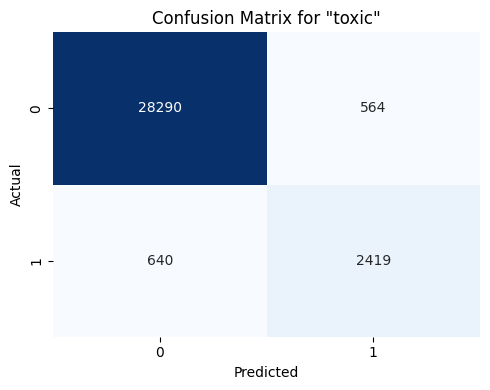

toxic confusion matrix:
[[28290   564]
 [  640  2419]]



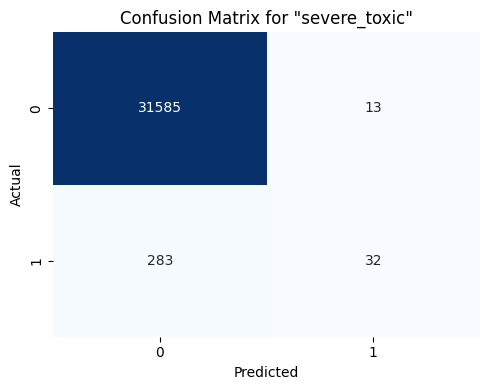

severe_toxic confusion matrix:
[[31585    13]
 [  283    32]]



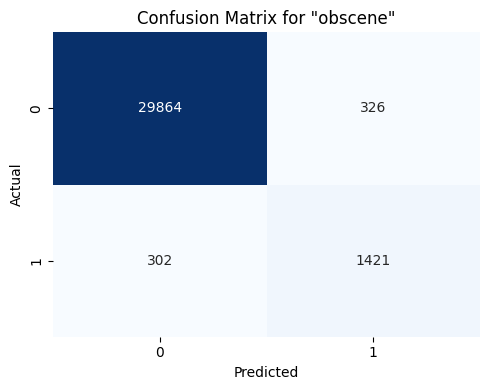

obscene confusion matrix:
[[29864   326]
 [  302  1421]]



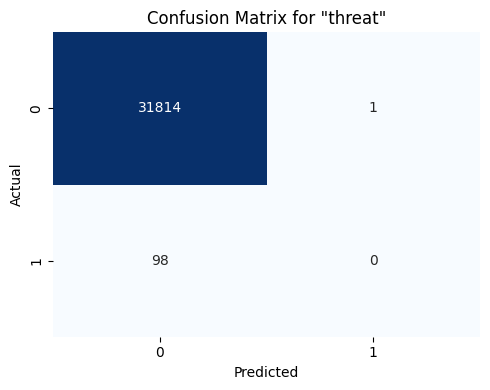

threat confusion matrix:
[[31814     1]
 [   98     0]]



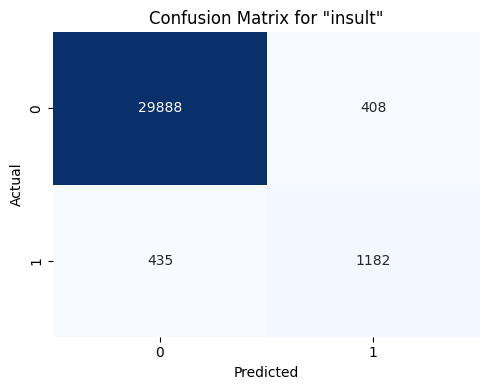

insult confusion matrix:
[[29888   408]
 [  435  1182]]



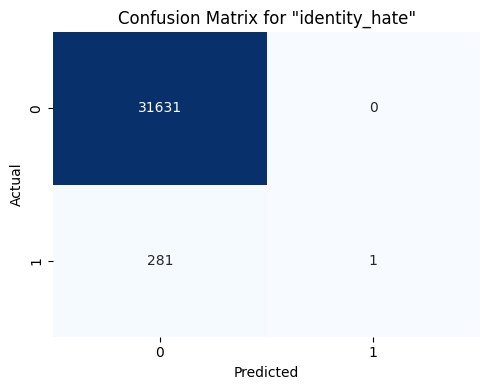

identity_hate confusion matrix:
[[31631     0]
 [  281     1]]



In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrices_per_label(model, X, y_true, label_names, save_dir=None, threshold=0.5):
    """
    Plot confusion matrix for each label in a multi-label classification problem.

    Args:
        model: Trained Keras model.
        X: Input features (tokenized sequences).
        y_true: True labels (DataFrame or numpy array).
        label_names: List of label names.
        save_dir: Directory to save confusion matrix plots (optional).
        threshold: Probability threshold for converting to binary predictions.
    """
    print("\n" + "="*50)
    print("CONFUSION MATRICES PER LABEL")
    print("="*50)

    # Predict probabilities and convert to binary predictions
    y_pred_prob = model.predict(X, verbose=1)
    y_pred = (y_pred_prob > threshold).astype(int)

    for i, label in enumerate(label_names):
        cm = confusion_matrix(y_true.iloc[:, i], y_pred[:, i])
        plt.figure(figsize=(5, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title(f'Confusion Matrix for "{label}"')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.tight_layout()

        if save_dir:
            os.makedirs(save_dir, exist_ok=True)
            plt.savefig(f"{save_dir}/confusion_matrix_{label}.png", dpi=300)

        plt.show()
        print(f"{label} confusion matrix:\n{cm}\n")


label_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

plot_confusion_matrices_per_label(
    model=model,
    X=X_val_tokens,
    y_true=y_val,
    label_names=label_names,
    save_dir=f"{results['experiment_dir']}/confusion_matrices"
)
